In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import os
import warnings
warnings.simplefilter('ignore')

### Load and Clean the Data
- Import raw dataset and transform it into the right format.
- I noticed that the columns were jumbled  that’s why I decided to split each line item based on Column Header

In [2]:
pwd = os.getcwd()

In [3]:
header = ["raw"]
df = pd.read_csv(os.path.basename(pwd +'/transactions.txt'),header=None, sep='\t', names=header)

In [4]:
df_subset = df.replace('"','', regex=True)

In [5]:
df_subset.raw = df_subset.raw.str[1:]
df_subset.raw = df_subset.raw.str[:-1]
df_subset.head()

,raw
0,"accountNumber: 737265056, customerId: 73726505..."
1,"accountNumber: 737265056, customerId: 73726505..."
2,"accountNumber: 737265056, customerId: 73726505..."
3,"accountNumber: 737265056, customerId: 73726505..."
4,"accountNumber: 830329091, customerId: 83032909..."


In [6]:
keys = ['accountnumber', 'customerid', 'creditlimit', 'availablemoney', 
        'transactiondatetime', 'transactionamount', 'merchantname', 'acqcountry',
        'merchantcountrycode', 'posentrymode', 'posconditioncode', 'merchantcategorycode',
        'currentexpdate', 'cardpresent', 'accountopendate', 'dateoflastaddresschange',
        'cardcvv', 'enteredcvv', 'cardlast4digits', 'transactiontype', 'echobuffer', 
        'currentbalance', 'merchantcity', 'merchantstate', 'merchantzip', 'cardpresent', 
        'posonpremises', 'recurringauthind', 'expirationdatekeyinmatch', 'isfraud']

- <b> Function parse_into_table:</b> Parse each line in Table and map each column with respective data
- <b> Function parse_raw       :</b> Split Columns at " , " and Column data at " : ".
- <b> Function map_to_list     :</b> Add column values to respective key

In [7]:
def parse_raw(raw_data):
    lines = raw_data.split(',')
    table = {}
    message = ''
    keys_to_extract = keys    
    for line in lines:
        
        pairs = line.split(':')  
        key = pairs[0].lower().replace(" ","")
        val = pairs[1].strip()
        
        if key in keys_to_extract:
            if val == '':
                table[key] = np.nan
            else:
                table[key] = val
    return table

In [8]:
def parse_into_table(data):
    table = [parse_raw(line) for line in data]
    return {
        key : map_to_list(table,key) for key in keys 
    }

In [9]:
def map_to_list(table, key):
    results = []
    for struc in table:
        
        if key not in struc:
            results.append('')
        else:
            results.append(struc[key])
    return results

In [10]:
df1 = pd.DataFrame(parse_into_table(df_subset.raw))

In [11]:
df1.head()

,accountnumber,customerid,creditlimit,availablemoney,transactiondatetime,transactionamount,merchantname,acqcountry,merchantcountrycode,posentrymode,...,transactiontype,echobuffer,currentbalance,merchantcity,merchantstate,merchantzip,posonpremises,recurringauthind,expirationdatekeyinmatch,isfraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14,98.55,Uber,US,US,02,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
1,737265056,737265056,5000.0,5000.0,2016-10-11T05,74.51,AMC #191138,US,US,09,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
2,737265056,737265056,5000.0,5000.0,2016-11-08T09,7.47,Play Store,US,US,09,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
3,737265056,737265056,5000.0,5000.0,2016-12-10T02,7.47,Play Store,US,US,09,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
4,830329091,830329091,5000.0,5000.0,2016-03-24T21,71.18,Tim Hortons #947751,US,US,02,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false


#### Structure of the data and Number of Null records 

In [12]:
"Dataset Dimensions: {}x{}".format(df1.shape[0], df1.shape[1])

'Dataset Dimensions: 786363x29'

In [13]:
df1.isnull().sum()

accountnumber                    0
customerid                       0
creditlimit                      0
availablemoney                   0
transactiondatetime              0
transactionamount                0
merchantname                     0
acqcountry                    4562
merchantcountrycode            724
posentrymode                  4054
posconditioncode               409
merchantcategorycode             0
currentexpdate                   0
cardpresent                      0
accountopendate                  0
dateoflastaddresschange          0
cardcvv                          0
enteredcvv                       0
cardlast4digits                  0
transactiontype                698
echobuffer                  786363
currentbalance                   0
merchantcity                786363
merchantstate               786363
merchantzip                 786363
posonpremises               786363
recurringauthind            786363
expirationdatekeyinmatch         0
isfraud             

Columns  <b> 'merchantcity', 'merchantstate', 'merchantzip', 'posonpremises', 'recurringauthind' and 'echobuffer' </b> are empty and removing these columns will have no effect on the final output

In [14]:
df1.drop(['merchantcity', 'merchantstate', 'merchantzip', 'posonpremises', 'recurringauthind', 'echobuffer'], axis=1, inplace=True)

In [15]:
df1[["creditlimit","transactionamount","availablemoney" ,"currentbalance"]] = df1[["creditlimit","transactionamount","availablemoney" ,  "currentbalance"]].apply(pd.to_numeric)

In [16]:
df1.dtypes

accountnumber                object
customerid                   object
creditlimit                 float64
availablemoney              float64
transactiondatetime          object
transactionamount           float64
merchantname                 object
acqcountry                   object
merchantcountrycode          object
posentrymode                 object
posconditioncode             object
merchantcategorycode         object
currentexpdate               object
cardpresent                  object
accountopendate              object
dateoflastaddresschange      object
cardcvv                      object
enteredcvv                   object
cardlast4digits              object
transactiontype              object
currentbalance              float64
expirationdatekeyinmatch     object
isfraud                      object
dtype: object

## Data Visualization

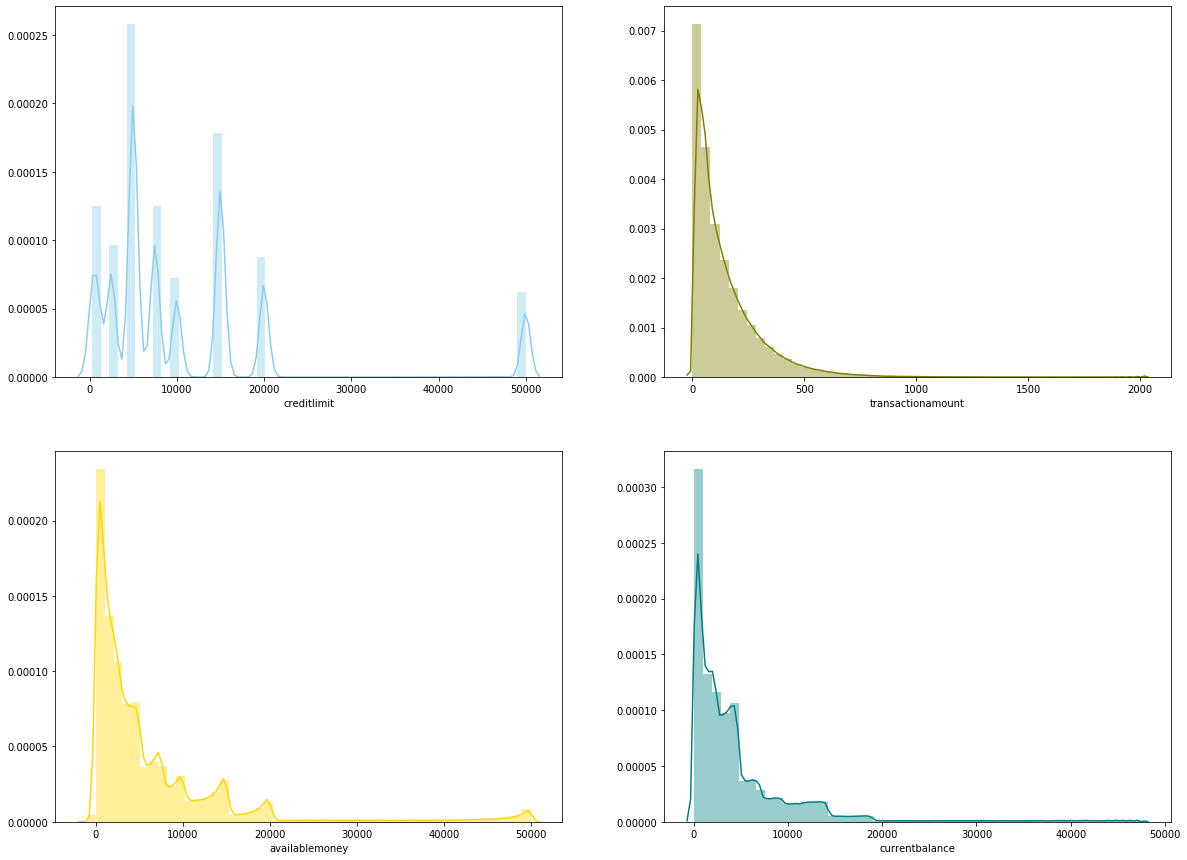

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

sns.distplot( df1["creditlimit"] , color="skyblue", ax=ax[0, 0])
sns.distplot( df1["transactionamount"] , color="olive", ax=ax[0, 1])
sns.distplot( df1["availablemoney"] , color="gold", ax=ax[1, 0])
sns.distplot( df1["currentbalance"] , color="teal", ax=ax[1, 1])

Since columns does not a similar value range we can't use single Boxplot to desplay them all 

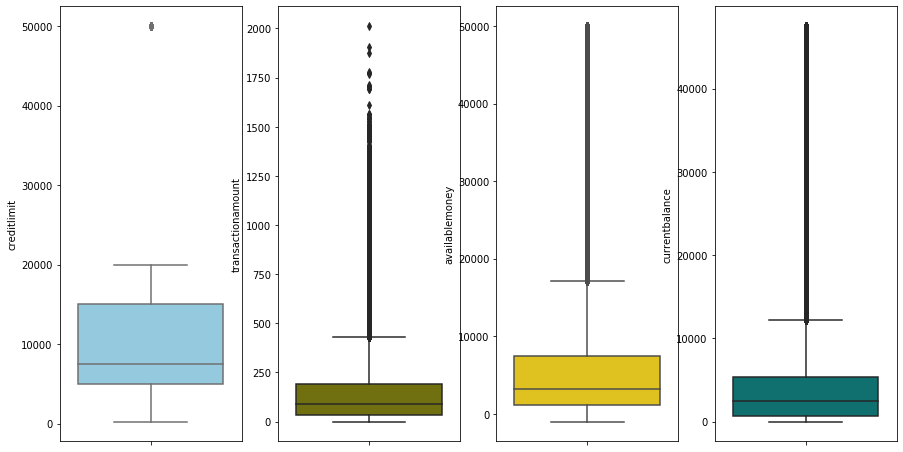

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(15,8))
sns.boxplot(ax=ax[0], x=df1['creditlimit'], orient='v',color="skyblue")
sns.boxplot(ax=ax[1], x=df1['transactionamount'], orient='v',color="olive")
sns.boxplot(ax=ax[2], x=df1['availablemoney'], orient='v',color="gold")
sns.boxplot(ax=ax[3], x=df1['currentbalance'], orient='v',color="teal")

### Hypotheses about the Data structure.
This Data certainly doesn’t follow a normal distribution and from the Box plot it is evident that Column Available money, Current Balance and Transactions have a lot of outliers

### Credit Limit
- Data have few Outliers
- Data is not Normally distributed
- Credit limit value is usually predefined by banks and it is evident from the data distribution

### Transaction Amount
- Data is highly Right skewed
- Majority of Transaction data closer to Zero, which implies that most of the customers don’t spend much

### Available Money
- Data is Right skewed
- If available credit is closer to 0, it means Customers don't have any/less credit for making purchases. This can happen if Customer maxed out their credit card

### Current Balance
- Data is Right skewed
- Current balance refers to all unpaid charges on an account, it makes sense that majority of the data have low current balance.

In [19]:
df1['creditlimit'].value_counts()

5000.0     201863
15000.0    139307
7500.0      97913
2500.0      75429
20000.0     68629
10000.0     56889
50000.0     48781
1000.0      36430
250.0       34025
500.0       27097
Name: creditlimit, dtype: int64

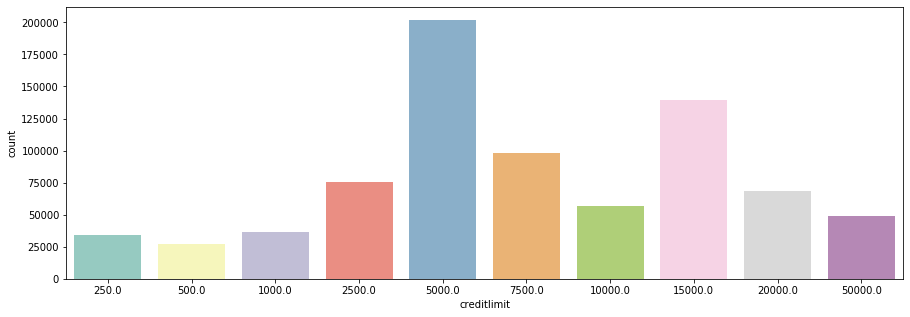

In [20]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x="creditlimit", data=df1, palette="Set3")

Text(0, 0.5, 'Transaction Amount')

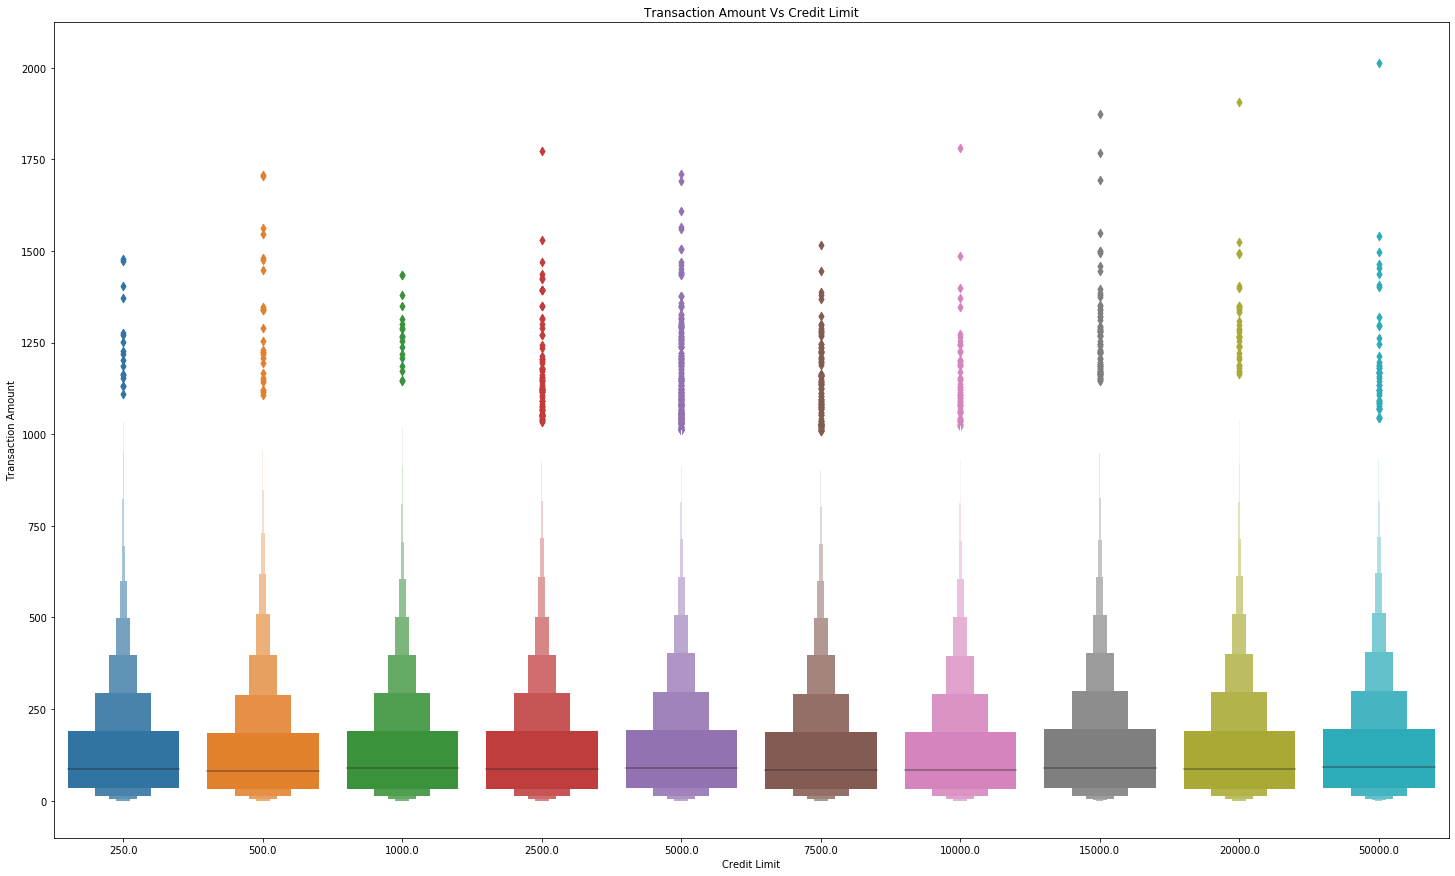

In [21]:
fig = plt.figure(figsize=(25,15)) 
sns.boxenplot(data=df1, x='creditlimit', y='transactionamount')
plt.title('Transaction Amount Vs Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Transaction Amount')

### This a data distribution by Merchant category code with majority data under Online retail category

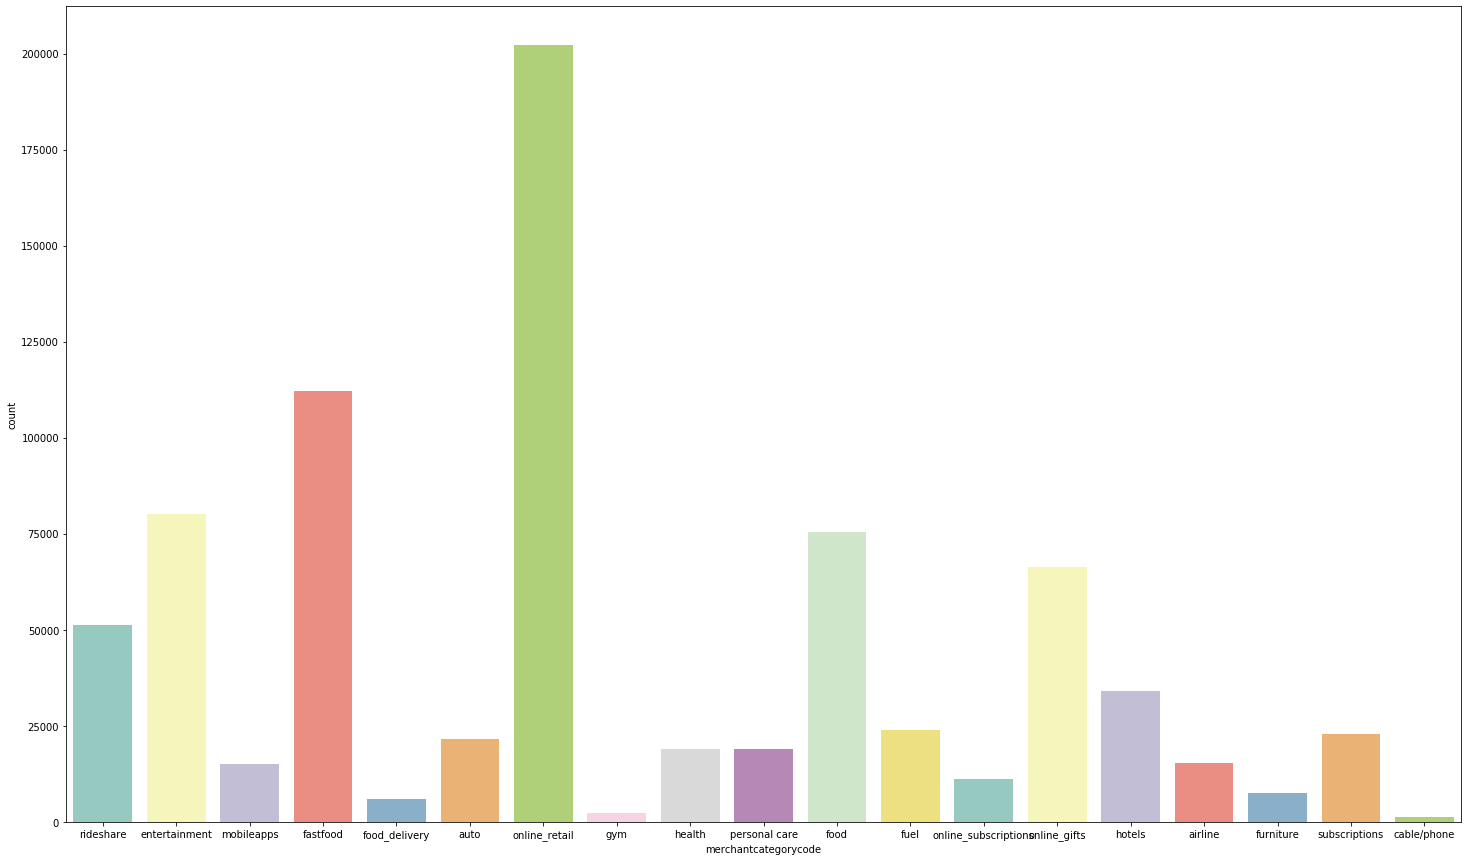

In [22]:
fig = plt.figure(figsize=(25,15)) 
ax = sns.countplot(x="merchantcategorycode", data=df1, palette="Set3")

Text(0.5, 1.0, 'Top 10 Merchants')

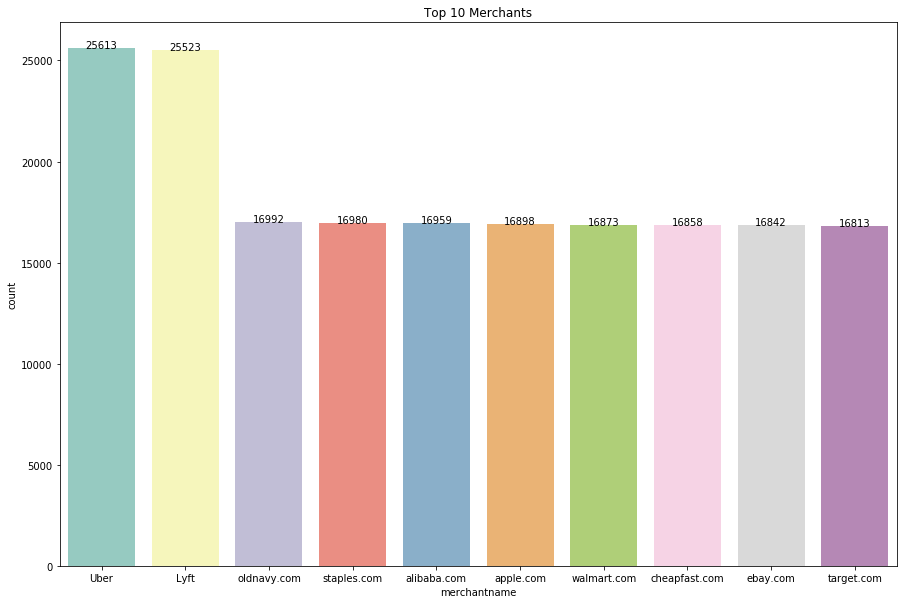

In [23]:
fig, ax1 = plt.subplots(figsize=(15,10))
graph = sns.countplot(ax=ax1,x='merchantname', data=df1,palette="Set3",
                  order=df1.merchantname.value_counts().iloc[:10].index)

graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.title('Top 10 Merchants')

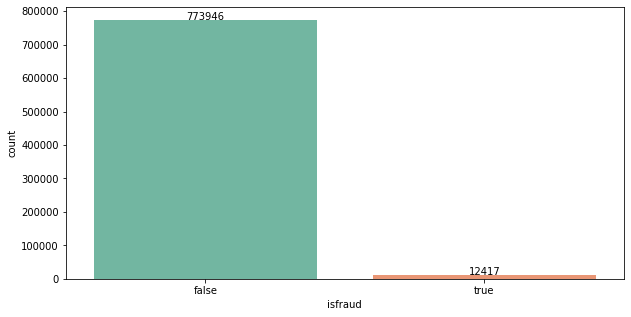

In [24]:
fig, ax1 = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax1,x='isfraud', data=df1,palette="Set2")
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Text(0.5, 1.0, 'POS Entry Mode')

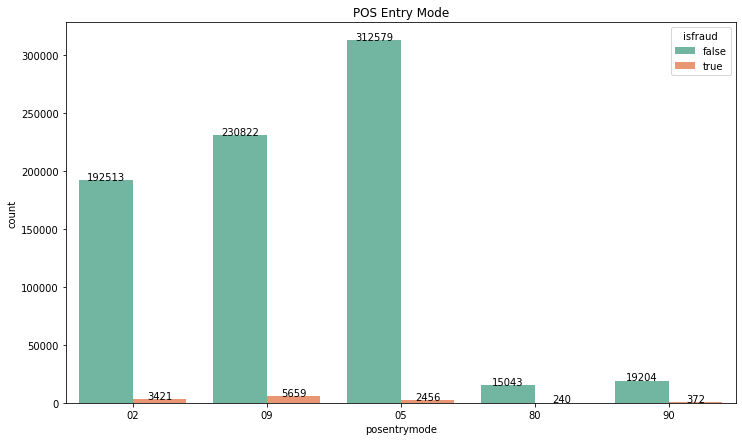

In [25]:
fig, ax1 = plt.subplots(figsize=(12,7))
graph =sns.countplot(data=df1, x='posentrymode', hue='isfraud',palette="Set2")
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.title('POS Entry Mode')

Text(0.5, 1.0, 'Transaction Type')

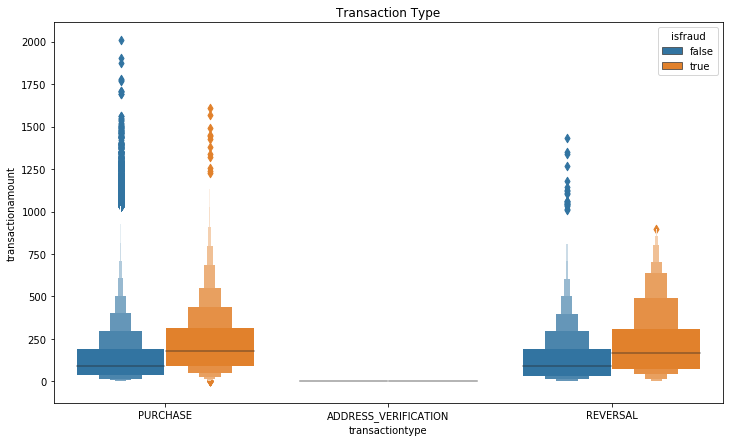

In [26]:
fig, ax1 = plt.subplots(figsize=(12,7))
sns.boxenplot(data=df1, y = 'transactionamount', x='transactiontype', hue='isfraud')
plt.title('Transaction Type')

### Data Wrangling - Duplicate Transactions

Converting Binary variables 

In [27]:
df1['correct_cvv'] = df1['cardcvv'] == df1['enteredcvv']
for col in ['cardpresent', 'expirationdatekeyinmatch', 'isfraud']:
    df1[col] = df1[col].replace({'false': 0, 'true': 1})
df1['correct_cvv'] = df1['correct_cvv'].replace({False: 0, True: 1})

In [28]:
df1 = df1.dropna()

In [29]:
df1.drop(['cardcvv', 'enteredcvv','dateoflastaddresschange','accountopendate',
          'cardlast4digits','currentexpdate','merchantname'],axis=1, inplace=True)

In [30]:
df_identify = df1.copy()
df_identify.drop(['acqcountry', 'merchantcountrycode','posentrymode',
          'expirationdatekeyinmatch','customerid'],axis=1, inplace=True)

Checking with just card swipe transaction

In [31]:
df_identify = df_identify[df_identify['cardpresent'] == 1]
df_identify.head()

,accountnumber,creditlimit,availablemoney,transactiondatetime,transactionamount,posconditioncode,merchantcategorycode,cardpresent,transactiontype,currentbalance,isfraud,correct_cvv
1,737265056,5000.0,5000.0,2016-10-11T05,74.51,01,entertainment,1,PURCHASE,0.0,0,1
4,830329091,5000.0,5000.0,2016-03-24T21,71.18,01,fastfood,1,PURCHASE,0.0,0,1
5,830329091,5000.0,5000.0,2016-04-19T16,30.76,01,fastfood,1,PURCHASE,0.0,0,1
6,830329091,5000.0,5000.0,2016-05-21T14,57.28,01,fastfood,1,PURCHASE,0.0,0,1
7,830329091,5000.0,5000.0,2016-06-03T00,9.37,01,fastfood,1,PURCHASE,0.0,0,1


- Assuming there are no transactions in between the reversed transactions
- My approach to solve this problem is to start with 1 account number with highest transaction data
- 570884863 has 9907 transaction details 
- Account number and CutomerID both the column has same details and hence one can be removed

In [32]:
df_acct = df_identify[df_identify['accountnumber'] == '570884863']
df_acct.drop(['posconditioncode','cardpresent','creditlimit','merchantcategorycode',
          'transactiontype','isfraud','correct_cvv'],axis=1, inplace=True)

#### - Convert transactiondatetime column to just Date, as it would be easier to Group by date and get duplicate values

In [33]:
df_acct['time'] = pd.to_datetime(df_acct['transactiondatetime']).dt.time

df_acct['transactiondatetime'] = pd.to_datetime(df_acct['transactiondatetime']).dt.date

df_acct.sort_values(['accountnumber','transactiondatetime']).groupby(['accountnumber','transactiondatetime', 'transactionamount']).size().reset_index()

,accountnumber,transactiondatetime,transactionamount,0
0,570884863,2016-01-01,7.87,1
1,570884863,2016-01-01,17.35,1
2,570884863,2016-01-01,34.66,1
3,570884863,2016-01-01,36.46,1
4,570884863,2016-01-01,37.32,1
...,...,...,...,...
9705,570884863,2016-12-30,300.20,1
9706,570884863,2016-12-30,368.19,1
9707,570884863,2016-12-30,445.54,1
9708,570884863,2016-12-30,504.96,1


In [34]:
df_acct['flag'] = df_acct.transactionamount.groupby([df_acct.transactiondatetime,
                                                     df_acct.transactionamount.diff().ne(0).cumsum()]).transform('size').ge(2).astype(int) 
df_acct['flag'].value_counts()


0    9541
1     366
Name: flag, dtype: int64

#### In total there are 183 ( 366/2 : 362 is orignal plus Duplicate )  Duplicate Transactions just for 570884863

In [35]:
df_acct = df_acct[df_acct['flag'] == 1]

#Sort by Date and Time
df_acct['diff'] = df_acct.sort_values(['accountnumber','transactiondatetime' ,'time']).groupby(['accountnumber','transactiondatetime', 'transactionamount'])['availablemoney'].diff().fillna(0).astype(float)

# Getting just a Single transaction ( reversed/multi-swipe )
df_acct = df_acct[df_acct['diff'] != 0]

df_acct['identity'] = np.where(df_acct['diff'] > 0, 'multi-swipe','reversed')

# Positive is Multi-swipe 
# Negative is Reverse 
df_acct


,accountnumber,availablemoney,transactiondatetime,transactionamount,currentbalance,time,flag,diff,identity
650854,570884863,2441.37,2016-01-02,0.19,2558.63,02:00:00,1,-0.19,reversed
650902,570884863,2913.42,2016-01-03,125.98,2086.58,19:00:00,1,-125.98,reversed
650944,570884863,1929.77,2016-01-05,21.53,3070.23,07:00:00,1,-21.53,reversed
651001,570884863,757.43,2016-01-07,145.78,4242.57,01:00:00,1,-145.78,reversed
651012,570884863,3159.12,2016-01-07,265.03,1840.88,10:00:00,1,2835.12,multi-swipe
...,...,...,...,...,...,...,...,...,...
661453,570884863,855.93,2016-12-22,88.73,4144.07,19:00:00,1,-88.73,reversed
661558,570884863,446.16,2016-12-26,202.58,4553.84,12:00:00,1,-202.58,reversed
661601,570884863,1971.65,2016-12-28,302.20,3028.35,02:00:00,1,-302.20,reversed
661642,570884863,2485.21,2016-12-29,59.75,2514.79,06:00:00,1,-59.75,reversed


In [36]:
df_acct['identity'].value_counts()

reversed       174
multi-swipe     14
Name: identity, dtype: int64

In [37]:
df_acct['diff'][df_acct["identity"]=='reversed'].sum()

-22076.270000000004

In [38]:
df_acct['diff'][df_acct["identity"]=='multi-swipe'].sum()

37880.25000000001

## Applying same methods to Complete data :df_identify

In [39]:
## Removing columns

df_identify.drop(['posconditioncode','cardpresent','creditlimit','merchantcategorycode',
          'transactiontype','isfraud','correct_cvv'],axis=1, inplace=True)

## Convert Date and Time in sepacrate 2 columns
df_identify['time'] = pd.to_datetime(df_identify['transactiondatetime']).dt.time
df_identify['transactiondatetime'] = pd.to_datetime(df_identify['transactiondatetime']).dt.date


df_identify.sort_values(['accountnumber','transactiondatetime']).groupby(['accountnumber','transactiondatetime', 'transactionamount']).size().reset_index()

## Create Flag column to indentify Duplicate transactions
df_identify['flag'] = df_identify.transactionamount.groupby([df_identify.transactiondatetime,
                                                     df_identify.transactionamount.diff().ne(0).cumsum()]).transform('size').ge(2).astype(int) 

## Filtering out just Duplicate transactions
df_identify = df_identify[df_identify['flag'] == 1]

#Sort by Date and Time
df_identify['diff'] = df_identify.sort_values(['accountnumber','transactiondatetime' ,'time']).groupby(['accountnumber','transactiondatetime', 'transactionamount'])['availablemoney'].diff().fillna(0).astype(float)

# Getting just a Single transaction ( reversed/multi-swipe )
df_identify = df_identify[df_identify['diff'] != 0]

## Categorizing into reversed or multi-swipe
df_identify['identity'] = np.where(df_identify['diff'] > 0, 'multi-swipe','reversed')

In [40]:
df_identify

,accountnumber,availablemoney,transactiondatetime,transactionamount,currentbalance,time,flag,diff,identity
39,574788567,2200.98,2016-05-24,215.13,299.02,01:00:00,1,-215.13,reversed
263,984504651,26680.99,2016-03-12,118.52,23319.01,06:00:00,1,-118.52,reversed
264,984504651,26562.47,2016-03-12,118.52,23437.53,06:00:00,1,-118.52,reversed
281,984504651,24316.12,2016-03-18,26.71,25683.88,13:00:00,1,-26.71,reversed
413,984504651,7302.32,2016-05-07,23.82,42697.68,07:00:00,1,-23.82,reversed
...,...,...,...,...,...,...,...,...,...
785587,841351704,13979.93,2016-12-27,206.92,36020.07,18:00:00,1,-206.92,reversed
785649,698607813,2385.71,2016-09-17,29.20,114.29,17:00:00,1,-29.20,reversed
785915,428856030,104.44,2016-10-30,314.07,145.56,20:00:00,1,-135.41,reversed
786120,638498773,9798.21,2016-01-01,201.79,201.79,19:00:00,1,-201.79,reversed


In [41]:
df_identify['identity'].value_counts()

reversed       5642
multi-swipe     392
Name: identity, dtype: int64

In [42]:
df_identify['diff'][df_identify["identity"]=='reversed'].sum()

-778848.6100000001

In [44]:
df_identify['diff'][df_identify["identity"]=='multi-swipe'].sum()

582887.63

### Preparing data for Model building

#### Removing columns which has no effect on the final output.
- Since accountNumber and customerId are a Unique identifier it will have no effect on the transaction being Fraud or Not.
- Merchant Name have 25613 unique variables 
- Created a column to check if entered CVV is matched to the Card CVV
- Date Of Last AddressChange and cards last 4 digits has no effect on determining fraud 

In [45]:
df1.drop(['accountnumber','customerid','transactiondatetime'],
         axis=1, inplace=True)

In [46]:
df1.isnull().sum()

creditlimit                 0
availablemoney              0
transactionamount           0
acqcountry                  0
merchantcountrycode         0
posentrymode                0
posconditioncode            0
merchantcategorycode        0
cardpresent                 0
transactiontype             0
currentbalance              0
expirationdatekeyinmatch    0
isfraud                     0
correct_cvv                 0
dtype: int64

In [47]:
df1 = df1.reindex(columns = ['creditlimit', 'availablemoney', 'transactionamount','currentbalance',
                  'acqcountry', 'merchantcountrycode', 'posentrymode', 'posconditioncode',
                  'merchantcategorycode', 'cardpresent', 'transactiontype', 
                  'expirationdatekeyinmatch','correct_cvv', 'isfraud'] )

In [48]:
df1.head()

,creditlimit,availablemoney,transactionamount,currentbalance,acqcountry,merchantcountrycode,posentrymode,posconditioncode,merchantcategorycode,cardpresent,transactiontype,expirationdatekeyinmatch,correct_cvv,isfraud
0,5000.0,5000.0,98.55,0.0,US,US,02,01,rideshare,0,PURCHASE,0,1,0
1,5000.0,5000.0,74.51,0.0,US,US,09,01,entertainment,1,PURCHASE,0,1,0
2,5000.0,5000.0,7.47,0.0,US,US,09,01,mobileapps,0,PURCHASE,0,1,0
3,5000.0,5000.0,7.47,0.0,US,US,09,01,mobileapps,0,PURCHASE,0,1,0
4,5000.0,5000.0,71.18,0.0,US,US,02,01,fastfood,1,PURCHASE,0,1,0


In [49]:
"Dataset Dimensions: {}x{}".format(df1.shape[0], df1.shape[1])

'Dataset Dimensions: 776668x14'

In [50]:
df1['posconditioncode'].value_counts()

01    621279
08    147973
99      7416
Name: posconditioncode, dtype: int64

changing categorical datatypes to category

In [51]:
df1.iloc[:,4:14] = df1.iloc[:,4:14].astype('category')

In [52]:
df1.dtypes

creditlimit                  float64
availablemoney               float64
transactionamount            float64
currentbalance               float64
acqcountry                  category
merchantcountrycode         category
posentrymode                category
posconditioncode            category
merchantcategorycode        category
cardpresent                 category
transactiontype             category
expirationdatekeyinmatch    category
correct_cvv                 category
isfraud                     category
dtype: object

## Model Building

In [53]:
#checking the split
print(df1["isfraud"].value_counts()/len(df1))

0    0.984593
1    0.015407
Name: isfraud, dtype: float64


### I tired doing Logistic regression with SMOTE over sampling, but I faced an issue of Null values when I resampled feature set using SMOTE()

### Resampling to get more balanced data

- Down-sampling (Under sampling) the majority class
- We can see that the split is extremely imbalanced, this split is also evident in the Bar graph shown above

In [54]:

ros = RandomOverSampler()

# Class count
count_class_0, count_class_1 = df1.isfraud.value_counts()

# Divide by class
df_class_0 = df1[df1['isfraud'] == 0]
df_class_1 = df1[df1['isfraud'] == 1]

Random under-sampling:
0    11966
1    11966
Name: isfraud, dtype: int64


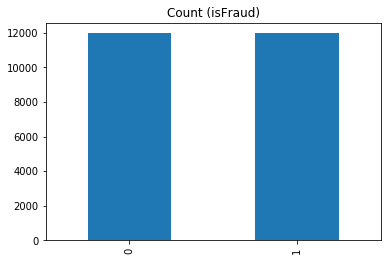

In [55]:
df_class_0_under = df_class_0.sample(count_class_1)
X = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(X.isfraud.value_counts())

X.isfraud.value_counts().plot(kind='bar', title='Count (isFraud)');

- Stratification will ensure that the samples evenly based on sample classes so that training set and validation set have similar ratio of classes

In [56]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:13],
                                                    X.iloc[:,-1],
                                                    stratify = X['isfraud'], test_size=0.3)

In [57]:
#checking the split
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.5
1    0.5
Name: isfraud, dtype: float64
0    0.5
1    0.5
Name: isfraud, dtype: float64


###  Scaling, Standardizing and Transformation are important steps of numeric feature and they used to treat skewed features and rescale them for modelling

In [58]:
le = LabelEncoder()

In [59]:
X_train["acqcountry"]=le.fit_transform(X_train["acqcountry"])
X_test["acqcountry"]= le.transform(X_test["acqcountry"])

X_train["merchantcountrycode"]=le.fit_transform(X_train["merchantcountrycode"])
X_test["merchantcountrycode"]= le.transform(X_test["merchantcountrycode"])

X_train["merchantcategorycode"]=le.fit_transform(X_train["merchantcategorycode"])
X_test["merchantcategorycode"]= le.transform(X_test["merchantcategorycode"])

X_train["transactiontype"]=le.fit_transform(X_train["transactiontype"])
X_test["transactiontype"]= le.transform(X_test["transactiontype"])


In [60]:
#Scaling the numerical features
categorical_columns = ['acqcountry','merchantcountrycode', 'posentrymode', 'posconditioncode',
                       'merchantcategorycode','cardpresent','transactiontype' ,'expirationdatekeyinmatch',
                       'correct_cvv']

X_train_1 = X_train[categorical_columns]
X_test_1 = X_test[categorical_columns]

scaler = StandardScaler()
standardized_numeric_data = scaler.fit_transform(X_train.drop(columns=categorical_columns))
X_train_final = np.concatenate((standardized_numeric_data,np.array(X_train_1)),axis=1)
standardized_numeric_data = scaler.transform(X_test.drop(columns=categorical_columns))
X_test_final = np.concatenate((standardized_numeric_data,np.array(X_test_1)),axis=1)

## Models

In [61]:
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [62]:
#model fitting
svc = svm.SVC(class_weight= 'balanced',C=1)
svc.fit(X_train_final, y_train)

SVC(C=1, class_weight='balanced')

In [63]:
y_predict = svc.predict(X_test_final)
svc_cm = [y_test, y_predict]

In [64]:
confusion_matrix(y_test,y_predict)

array([[2618,  972],
       [1496, 2094]], dtype=int64)

In [65]:
accuracy = accuracy_score(y_test,y_predict)
print(accuracy)

0.6562674094707521


In [66]:

report = classification_report(y_test,y_predict)
print(report)


              precision    recall  f1-score   support

           0       0.64      0.73      0.68      3590
           1       0.68      0.58      0.63      3590

    accuracy                           0.66      7180
   macro avg       0.66      0.66      0.65      7180
weighted avg       0.66      0.66      0.65      7180



## Logistic Regression

In [67]:
LR = LogisticRegression().fit(X_train_final, y_train)

In [68]:
y_predict = LR.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
lr_cm = [y_test, y_predict]
print(accuracy)

0.650974930362117


In [69]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.69      0.66      3590
           1       0.66      0.62      0.64      3590

    accuracy                           0.65      7180
   macro avg       0.65      0.65      0.65      7180
weighted avg       0.65      0.65      0.65      7180



## Support Vector Machines

In [70]:
SVM = svm.LinearSVC().fit(X_train_final, y_train)

In [71]:
y_predict = SVM.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
svm_cm = [y_test, y_predict]
print(accuracy)

0.628133704735376


In [72]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.76      0.67      3590
           1       0.68      0.49      0.57      3590

    accuracy                           0.63      7180
   macro avg       0.64      0.63      0.62      7180
weighted avg       0.64      0.63      0.62      7180



## Random Forests

In [73]:
RF = RandomForestClassifier().fit(X_train_final, y_train)
y_predict = RF.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
rf_cm = [y_test, y_predict]
print(accuracy)

0.6832869080779944


In [74]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      3590
           1       0.69      0.68      0.68      3590

    accuracy                           0.68      7180
   macro avg       0.68      0.68      0.68      7180
weighted avg       0.68      0.68      0.68      7180



## Neural Networks

In [75]:
NN = MLPClassifier( hidden_layer_sizes=(5, 2), random_state=1).fit(X_train_final, y_train)

In [76]:
y_predict = NN.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
nn_cm = [y_test, y_predict]
print(accuracy)

0.6559888579387186


In [77]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.71      0.67      3590
           1       0.68      0.60      0.64      3590

    accuracy                           0.66      7180
   macro avg       0.66      0.66      0.65      7180
weighted avg       0.66      0.66      0.65      7180



## XGBoost :Gradient boosted decision trees

In [78]:
XG = XGBClassifier().fit(X_train_final, y_train)

[11:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [79]:
y_predict = XG.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
xg_cm = [y_test, y_predict]
print(accuracy)

0.7


In [80]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      3590
           1       0.70      0.71      0.70      3590

    accuracy                           0.70      7180
   macro avg       0.70      0.70      0.70      7180
weighted avg       0.70      0.70      0.70      7180



In [81]:
def plot_roc(models):
    fig = plt.figure(figsize=(15,10)) 
    for key, value in models.items():
        fpr, tpr, _ = roc_curve(value[0], value[1])
        sns.lineplot(x=fpr, y=tpr, label=key)

    ax = sns.lineplot(x=[0, 0.5, 1], y=[0, 0.5, 1])
    ax.lines[len(models)].set_linestyle("--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')

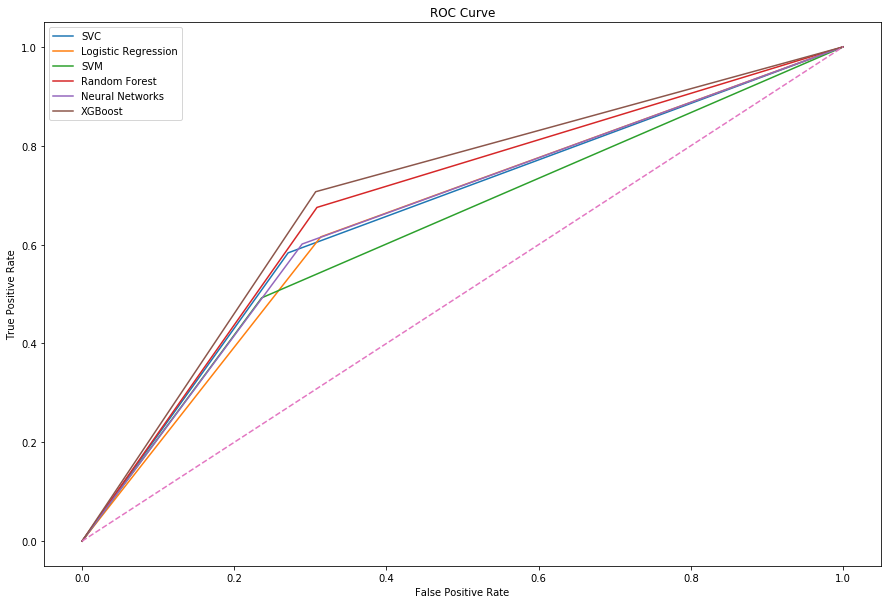

In [82]:
results = { 'SVC': svc_cm,'Logistic Regression': lr_cm,'SVM': svm_cm,
            'Random Forest': rf_cm,'Neural Networks': nn_cm,
            'XGBoost': xg_cm }
plot_roc(results)